# Volcanic Eruption Impact on Climate from FLOR Ensemble: Pinatubo 1991
* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [2]:
%matplotlib notebook
!date

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
from scipy.stats import ttest_1samp

from plotsetting import *
from geoplots import mapplot, xticksyear, xticksmonth
import geoxarray

Tue Mar 27 15:58:06 EDT 2018


In [3]:
from data_CTL1860 import open_ensemble as get_ctl
from data_pinatubo import open_data as get_volcano
volcano_name = 'Pinatubo'
year_volcano = 1991
ens = range(1,31)
nbname = 'volcano_impact_on_climate_pinatubo.ipynb'
new_names = {'grid_xt': 'lon', 'grid_yt': 'lat'}

## Net radiation (lw+sw) at TOA ``netrad_toa``

In [4]:
data_name = 'netrad_toa'
# da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
# da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.netrad_toa.ctl.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.netrad_toa.nc


### Time series

In [5]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


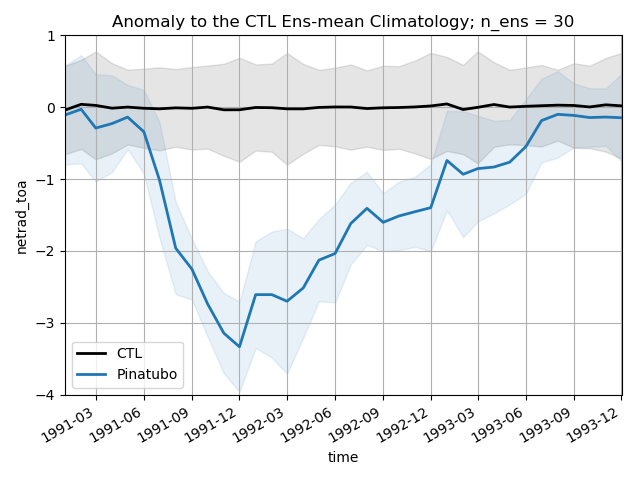

In [6]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(3,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-4,1)
plt.tight_layout()

<IPython.core.display.Javascript object>


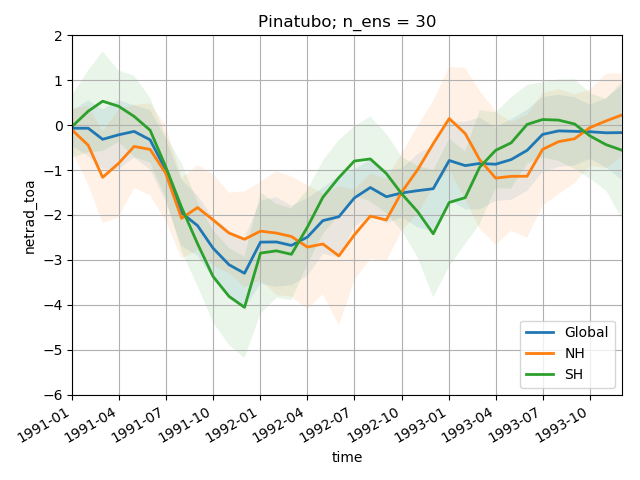

In [7]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    tsa.mean('en') - tsa.std('en'),
#     ts_ctl.max('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa.time.isel(time=[0,-1]).to_index())
plt.ylim(-6,2)
plt.legend(frameon=True, loc='lower right')
plt.tight_layout()

### Seasonal mean

In [50]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


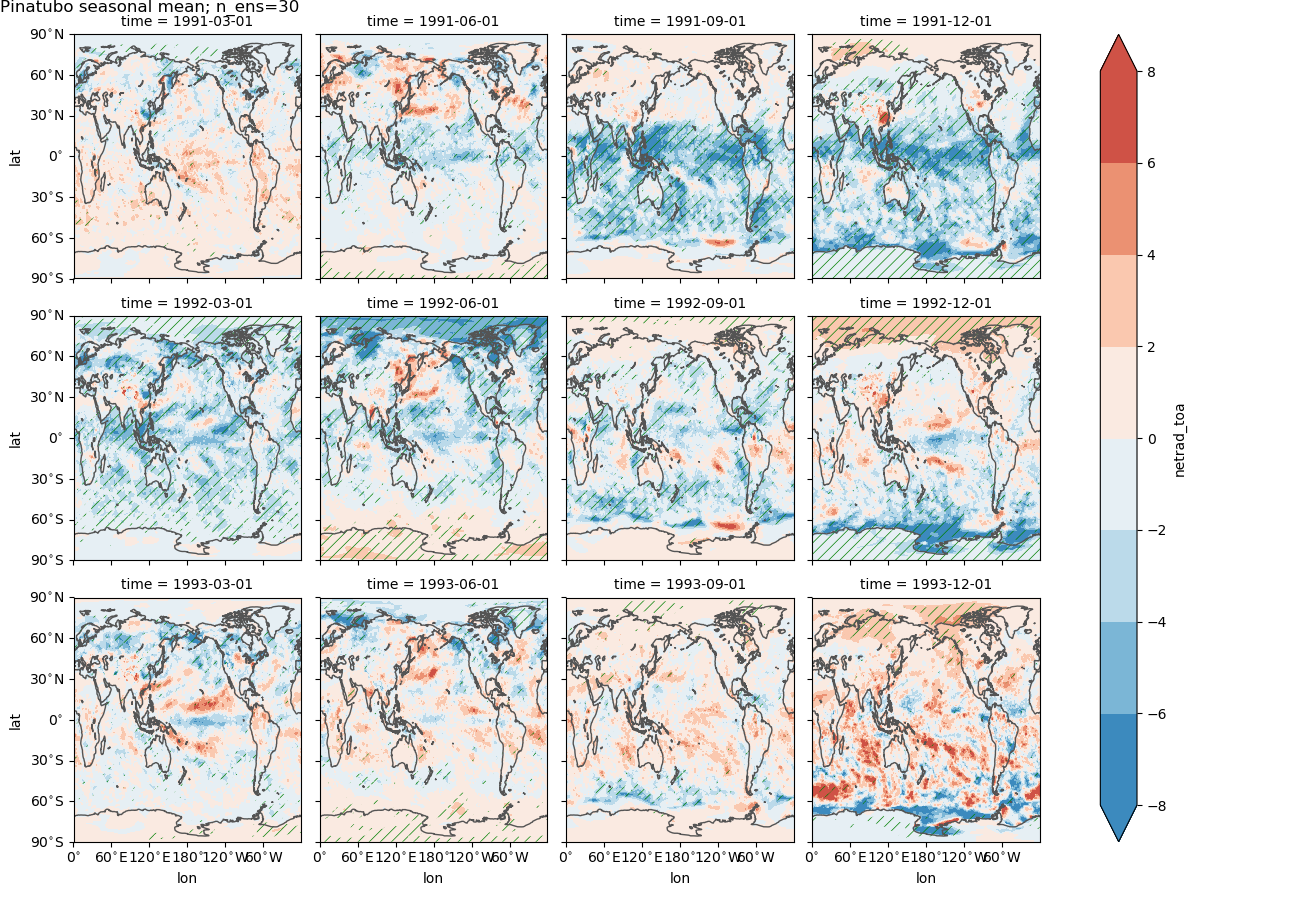

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [51]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name} seasonal mean; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal mean

In [52]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

<IPython.core.display.Javascript object>


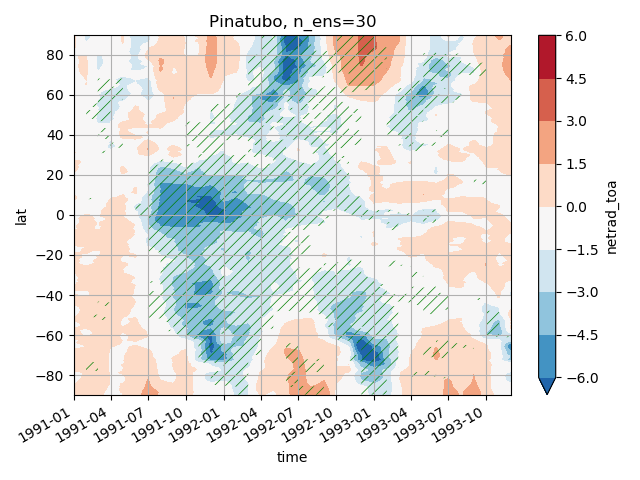

In [53]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

## Surface downward solar radiation ``swdn_sfc``

In [8]:
data_name = 'swdn_sfc'
# da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
# da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.swdn_sfc.ctl.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.swdn_sfc.nc


### Time series

In [9]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


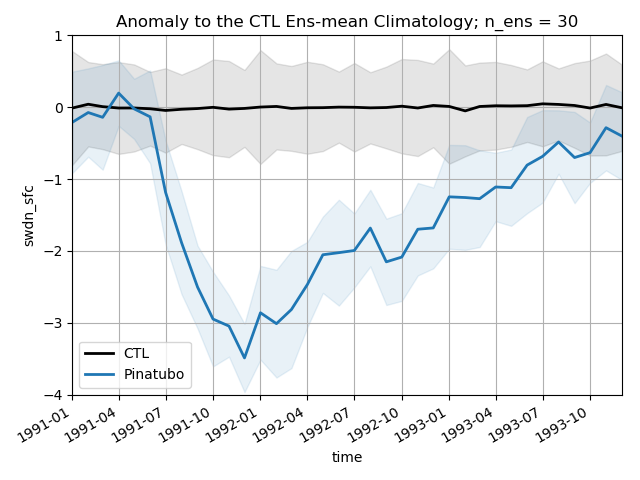

In [10]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-4,1)
plt.tight_layout()

<IPython.core.display.Javascript object>


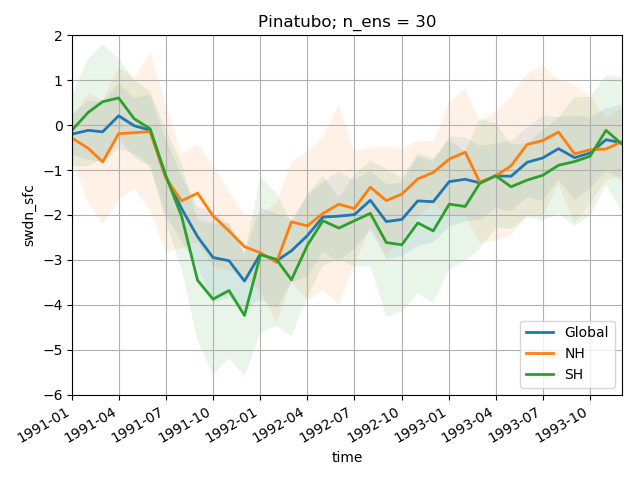

In [11]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
    tsa.mean('en') - tsa.std('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa.isel(time=[0,-1]).time.to_index())
plt.ylim(-6,2)
plt.legend(frameon=True, loc='lower right')
plt.tight_layout()

### Seasonal mean

In [58]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


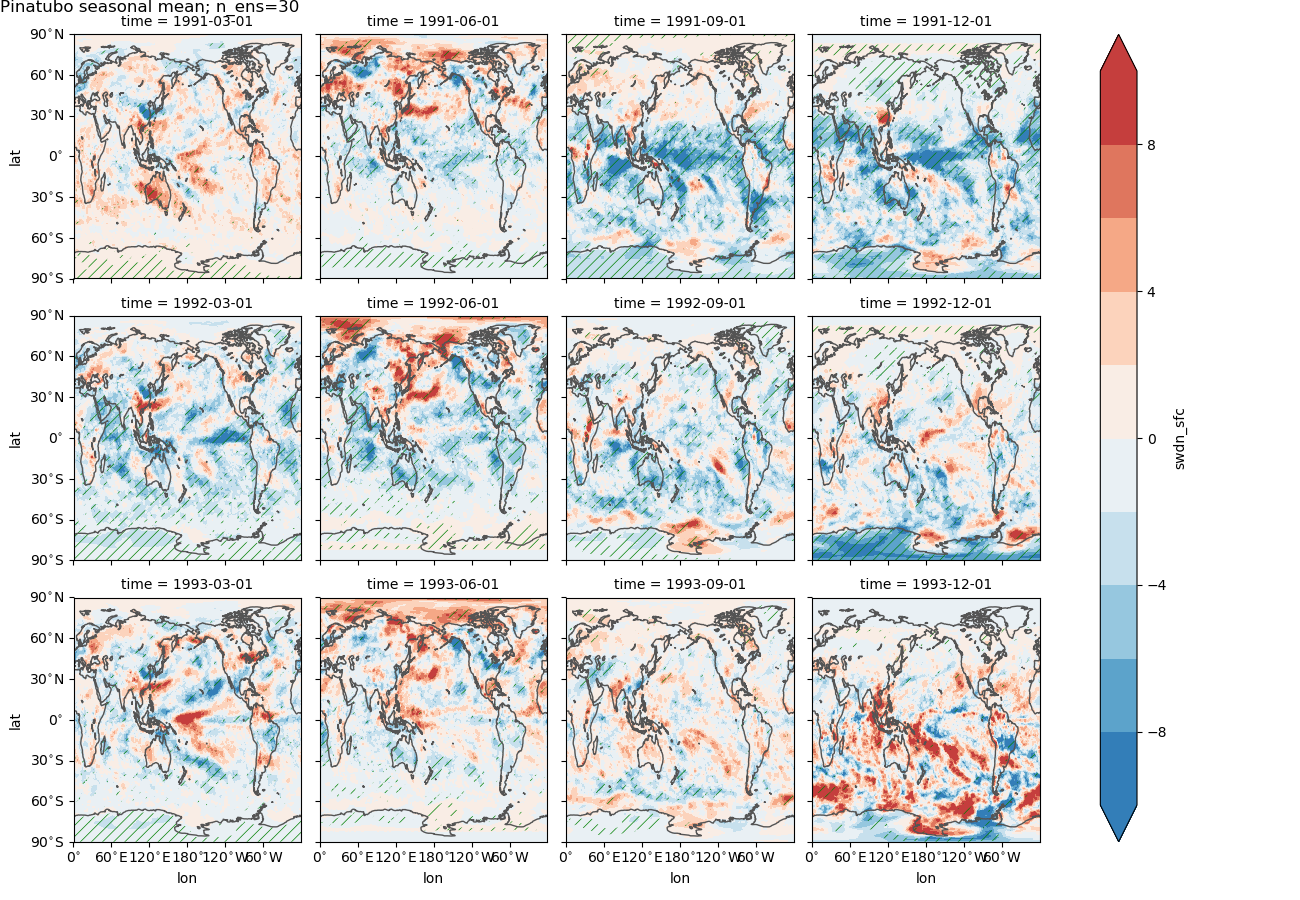

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [59]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name} seasonal mean; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal mean

In [60]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<IPython.core.display.Javascript object>


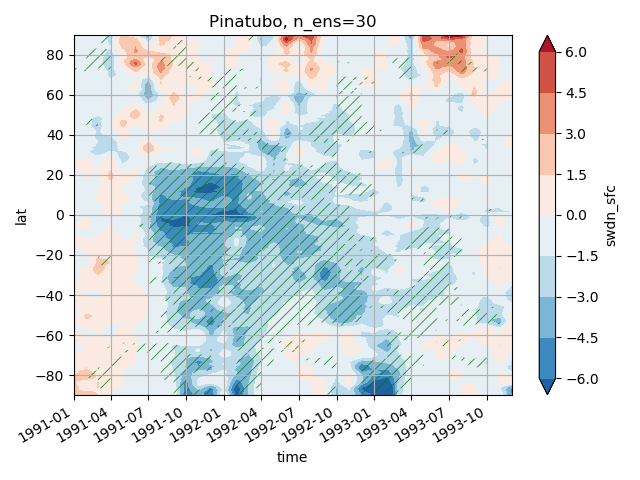

In [61]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

## Surface temperature ``t_surf``

In [12]:
data_name = 't_surf'
# da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
# da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.t_surf.ctl.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.t_surf.nc


### Time series

In [13]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


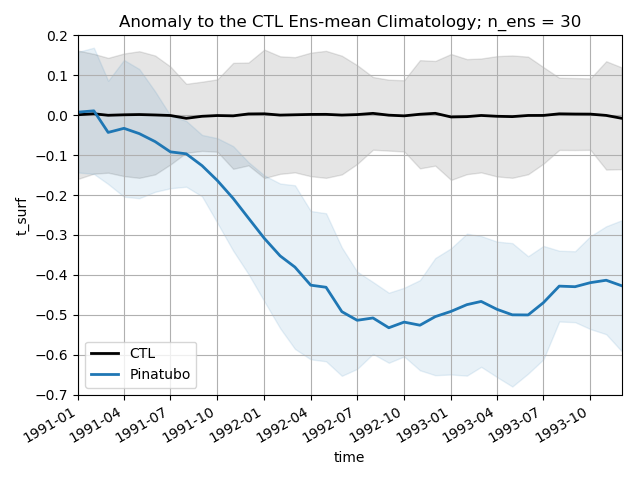

In [14]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-.7,.2)
plt.tight_layout()

<IPython.core.display.Javascript object>


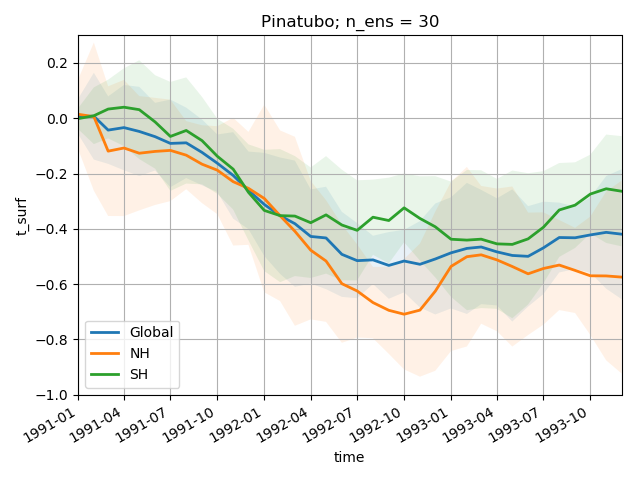

In [15]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
    tsa.mean('en') - tsa.std('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa.isel(time=[0,-1]).time.to_index())
plt.ylim(-1,.3)
plt.legend(frameon=True, loc='lower left')
plt.tight_layout()

### Seasonal mean

In [69]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


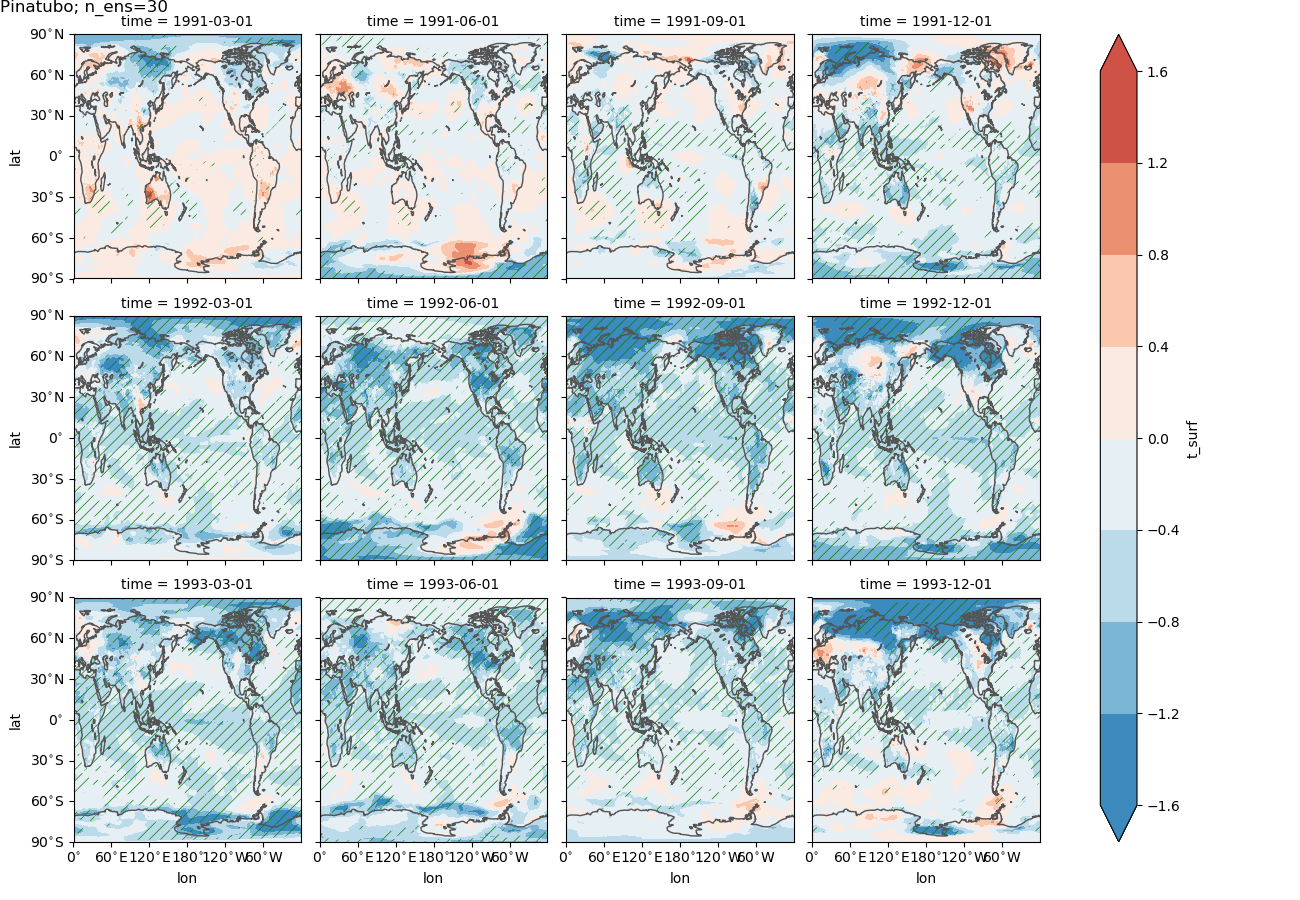

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [70]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


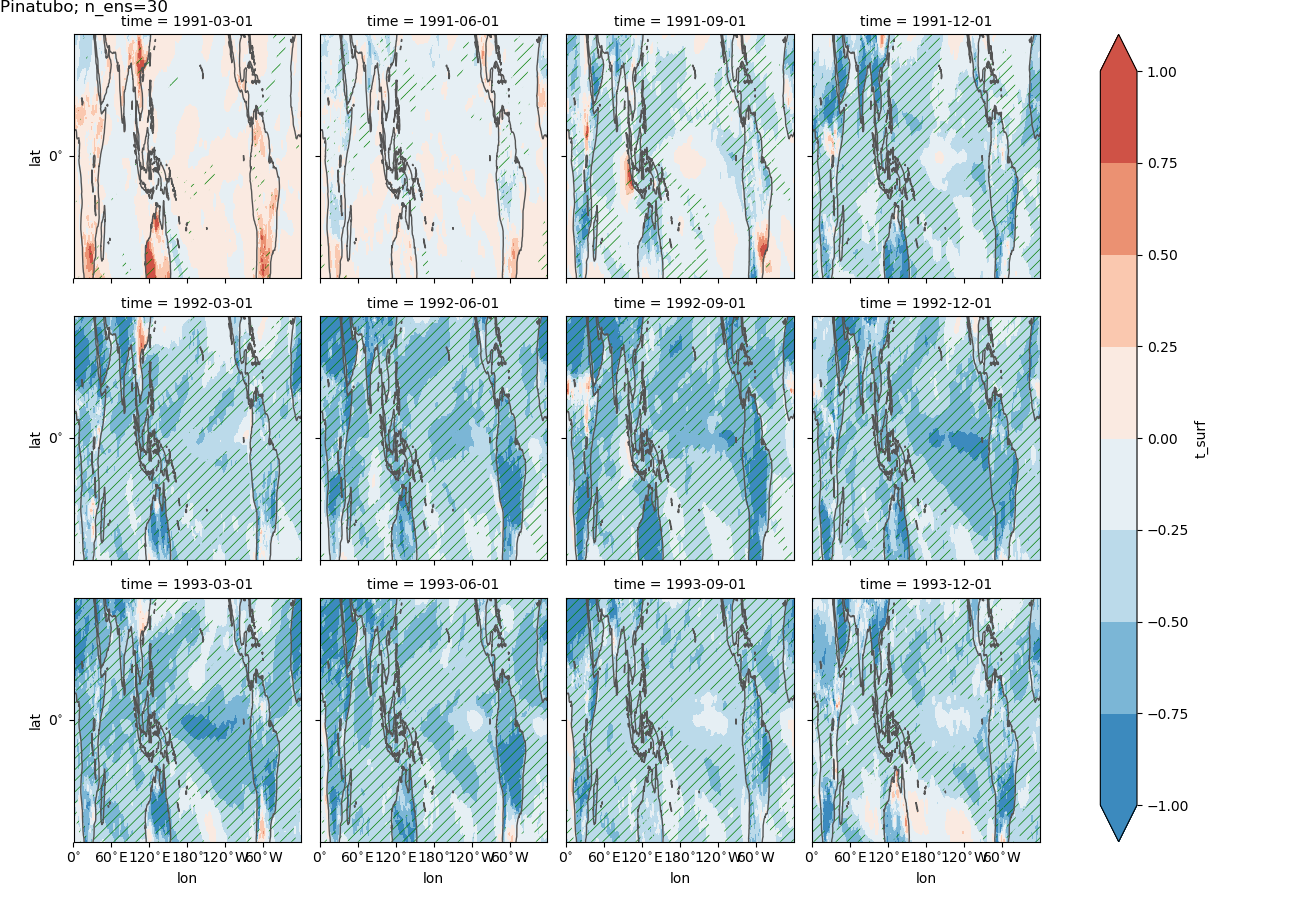

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [71]:
# tropics only
latrange = slice(-30,30)
f = da.sel(lat=latrange).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=latrange).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal mean

In [72]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

<IPython.core.display.Javascript object>


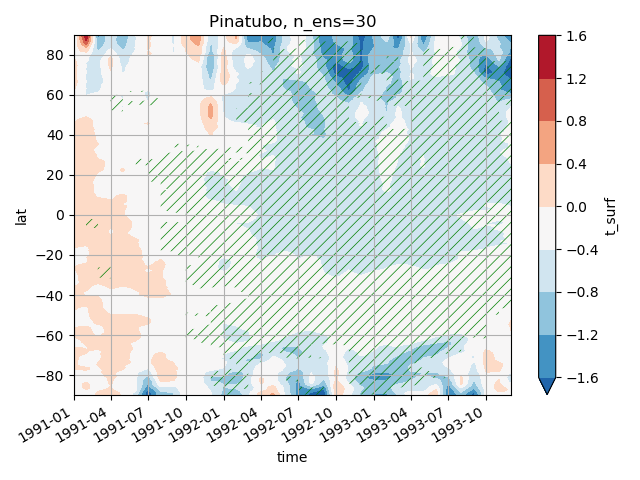

In [73]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0)
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

### ENSO

In [16]:
# ENSO areas are defined from: 
# https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni
lons = dict(nino12=slice(360-90,360-80), 
    nino3=slice(360-150, 360-90),
    nino34=slice(360-170, 360-120),
    nino4=slice(160, 360-150))
lats = dict(nino12=slice(-10,0),
    nino3=slice(-5,5),
    nino34=slice(-5,5),
    nino4=slice(-5,5))
ts_ctl = da_ctl.sel(lon=lons['nino34'], lat=lats['nino34']).geo.fldmean()
ts_volc = da_volcano.sel(lon=lons['nino34'], lat=lats['nino34']).geo.fldmean()
ts_ctl_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
tsa_ctl = ts_ctl.groupby('time.month') - ts_ctl_clim
tsa_volc = ts_volc.groupby('time.month') - ts_ctl_clim

<IPython.core.display.Javascript object>


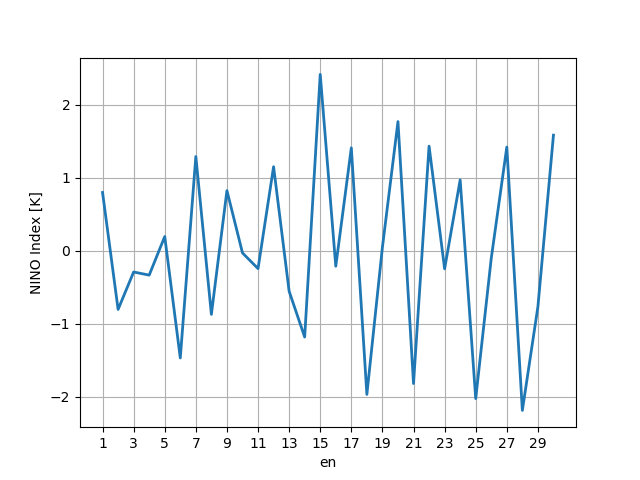

Nino ens: [ 7  9 12 15 17 20 22 24 27 30]
Nina ens: [ 2  6  8 13 14 18 21 25 28 29]
Neut ens: [1, 3, 4, 5, 10, 11, 16, 19, 23, 26]


In [17]:
# nino_i = tsa_volc.sel(time='1991-01').squeeze()
nino_i = tsa_ctl.sel(time=slice('1991-10', '1991-12')).mean('time')
ens_dict = dict()
ens_dict['nino'] = nino_i.en[nino_i > nino_i.quantile(0.67)].values
ens_dict['nina'] = nino_i.en[nino_i < nino_i.quantile(0.33)].values
ens_dict['neut'] = [en for en in range(1,31) if en not in ens_dict['nino'] and en not in ens_dict['nina']]
nino_i.plot()
plt.xticks(range(1,31,2))
plt.ylabel('NINO Index [K]')
plt.grid(True)
print('Nino ens:', ens_dict['nino'])
print('Nina ens:', ens_dict['nina'])
print('Neut ens:', ens_dict['neut'])

<IPython.core.display.Javascript object>


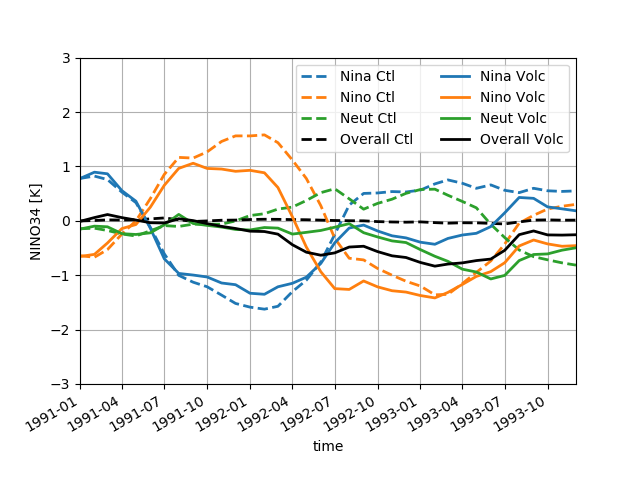

In [19]:
tsa_ctl.sel(en=ens_dict['nina']).mean('en').plot(label='Nina Ctl', color='C0', linestyle='--')
tsa_ctl.sel(en=ens_dict['nino']).mean('en').plot(label='Nino Ctl', color='C1', linestyle='--')
tsa_ctl.sel(en=ens_dict['neut']).mean('en').plot(label='Neut Ctl', color='C2', linestyle='--')
tsa_ctl.sel().mean('en').plot(label='Overall Ctl', color='k', linestyle='--')

tsa_volc.sel(en=ens_dict['nina']).mean('en').plot(label='Nina Volc', color='C0', linestyle='-')
tsa_volc.sel(en=ens_dict['nino']).mean('en').plot(label='Nino Volc', color='C1', linestyle='-')
tsa_volc.sel(en=ens_dict['neut']).mean('en').plot(label='Neut Volc', color='C2', linestyle='-')
tsa_volc.sel().mean('en').plot(label='Overall Volc', color='k', linestyle='-')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa_ctl.time.isel(time=[0,-1]).to_index())
plt.ylim(-3,3)
plt.ylabel('NINO34 [K]')
plt.legend(frameon=True, loc='upper right', ncol=2)

<IPython.core.display.Javascript object>


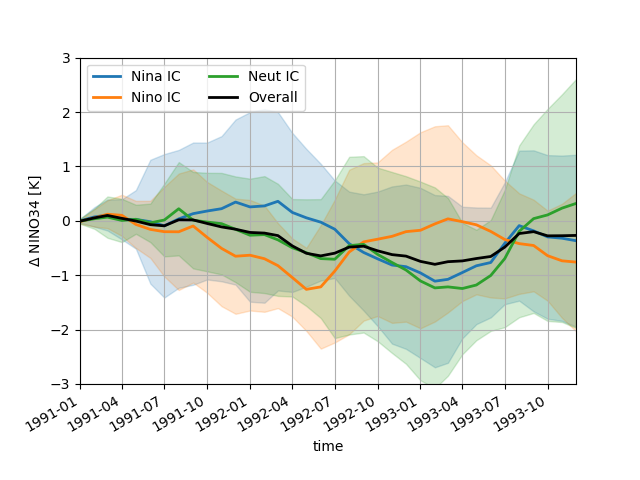

Text(0,0.5,'$\\Delta$ NINO34 [K]')

In [21]:
tsaa = (tsa_volc - tsa_ctl).sel(en=ens_dict['nina'])
plt.fill_between(tsaa.time.to_index().to_pydatetime(),
    tsaa.mean('en') - tsaa.std('en'),
    tsaa.mean('en') + tsaa.std('en'),
    alpha=0.2, color='C0')
tsaa.mean('en').plot(label='Nina IC',color='C0')

tsaa = (tsa_volc - tsa_ctl).sel(en=ens_dict['nino'])
plt.fill_between(tsaa.time.to_index().to_pydatetime(),
    tsaa.mean('en') - tsaa.std('en'),
    tsaa.mean('en') + tsaa.std('en'),
    alpha=0.2, color='C1')
tsaa.mean('en').plot(label='Nino IC', color='C1')

tsaa = (tsa_volc - tsa_ctl).sel(en=ens_dict['neut'])
plt.fill_between(tsaa.time.to_index().to_pydatetime(),
    tsaa.mean('en') - tsaa.std('en'),
    tsaa.mean('en') + tsaa.std('en'),
    alpha=0.2, color='C2')
tsaa.mean('en').plot(label='Neut IC', color='C2')

tsaa = (tsa_volc - tsa_ctl)
tsaa.mean('en').plot(label='Overall', color='k')

plt.legend(frameon=True, loc='upper left', ncol=2)
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsaa.time.isel(time=[0,-1]).to_index())
plt.ylim(-3,3)
plt.ylabel('$\Delta$ NINO34 [K]')

## Precipitation ``precip``

In [22]:
data_name = 'precip'
scale_factor = 3600*24
# da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load().pipe(lambda x: x*scale_factor)
# da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load().pipe(lambda x: x*scale_factor)
ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

da_ctl = da_ctl * scale_factor
da_volcano = da_volcano * scale_factor

Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.precip.ctl.nc
Data loaded from cache/volcano_impact_on_climate_pinatubo.ipynb.precip.nc


### Time series

In [23]:
# global mean time series
ts_ctl = da_ctl.geo.fldmean()
ts_volcano = da_volcano.geo.fldmean()
tsa = ts_volcano - ts_ctl
# NH and SH mean time series
tsas = dict(NH=(da_volcano - da_ctl).sel(lat=slice(0,90)).geo.fldmean(),
           SH=(da_volcano - da_ctl).sel(lat=slice(-90,0)).geo.fldmean())

# remove monthly climatology of CTL
ts_clim = ts_ctl.groupby('time.month').mean(['time', 'en'])
ts_volcano = ts_volcano.groupby('time.month') - ts_clim
ts_ctl = ts_ctl.groupby('time.month') - ts_clim

<IPython.core.display.Javascript object>


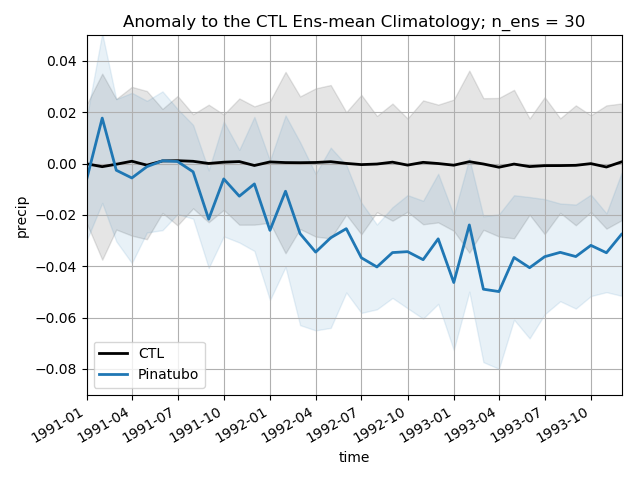

In [24]:
plt.fill_between(ts_ctl.time.to_index().to_pydatetime(),
#     ts_ctl.min('en'),
    ts_ctl.mean('en') - ts_ctl.std('en'),
#     ts_ctl.max('en'),
    ts_ctl.mean('en') + ts_ctl.std('en'),
    color='k', alpha=0.1)
plt.fill_between(ts_volcano.time.to_index().to_pydatetime(),
#     ts_volcano.min('en'),
    ts_volcano.mean('en') - ts_volcano.std('en'),
#     ts_volcano.max('en'),
    ts_volcano.mean('en') + ts_volcano.std('en'),
    color='C0', alpha=0.1)
ts_ctl.mean('en').plot(color='k', label='CTL')
ts_volcano.mean('en').plot(color='C0', label=volcano_name)
plt.legend(loc='lower left', frameon=True)
plt.ylabel(f'{data_name}')
plt.title(f'Anomaly to the CTL Ens-mean Climatology; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(ts_ctl.isel(time=[0,-1]).time.to_index())
plt.ylim(-.09,.05)
plt.tight_layout()

<IPython.core.display.Javascript object>


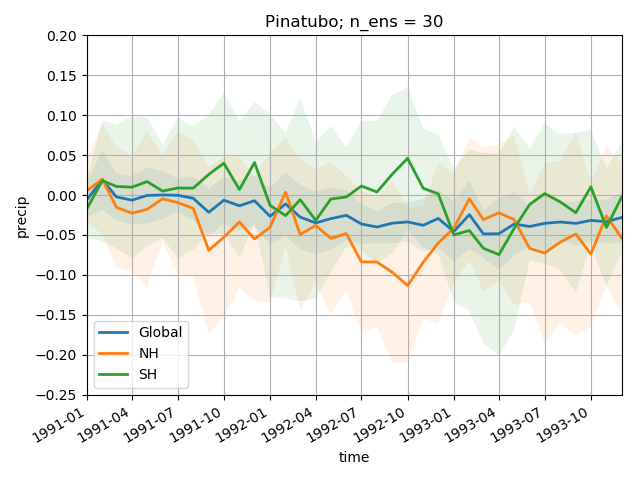

In [25]:
plt.fill_between(tsa.time.to_index().to_pydatetime(),
    tsa.mean('en') - tsa.std('en'),
    tsa.mean('en') + tsa.std('en'),
    alpha=0.1)
tsa.mean('en').plot(label='Global')

for key in ['NH', 'SH']:
    plt.fill_between(tsas[key].time.to_index().to_pydatetime(),
        tsas[key].mean('en') - tsas[key].std('en'),
    #     ts_ctl.max('en'),
        tsas[key].mean('en') + tsas[key].std('en'),
        alpha=0.1)
    tsas[key].mean('en').plot(label=key)

plt.ylabel(f'{data_name}')
plt.title(f'{volcano_name}; n_ens = {len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(tsa.isel(time=[0,-1]).time.to_index())
plt.ylim(-.25,.20)
plt.legend(frameon=True, loc='lower left')
plt.tight_layout()

### Seasonal mean

In [86]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


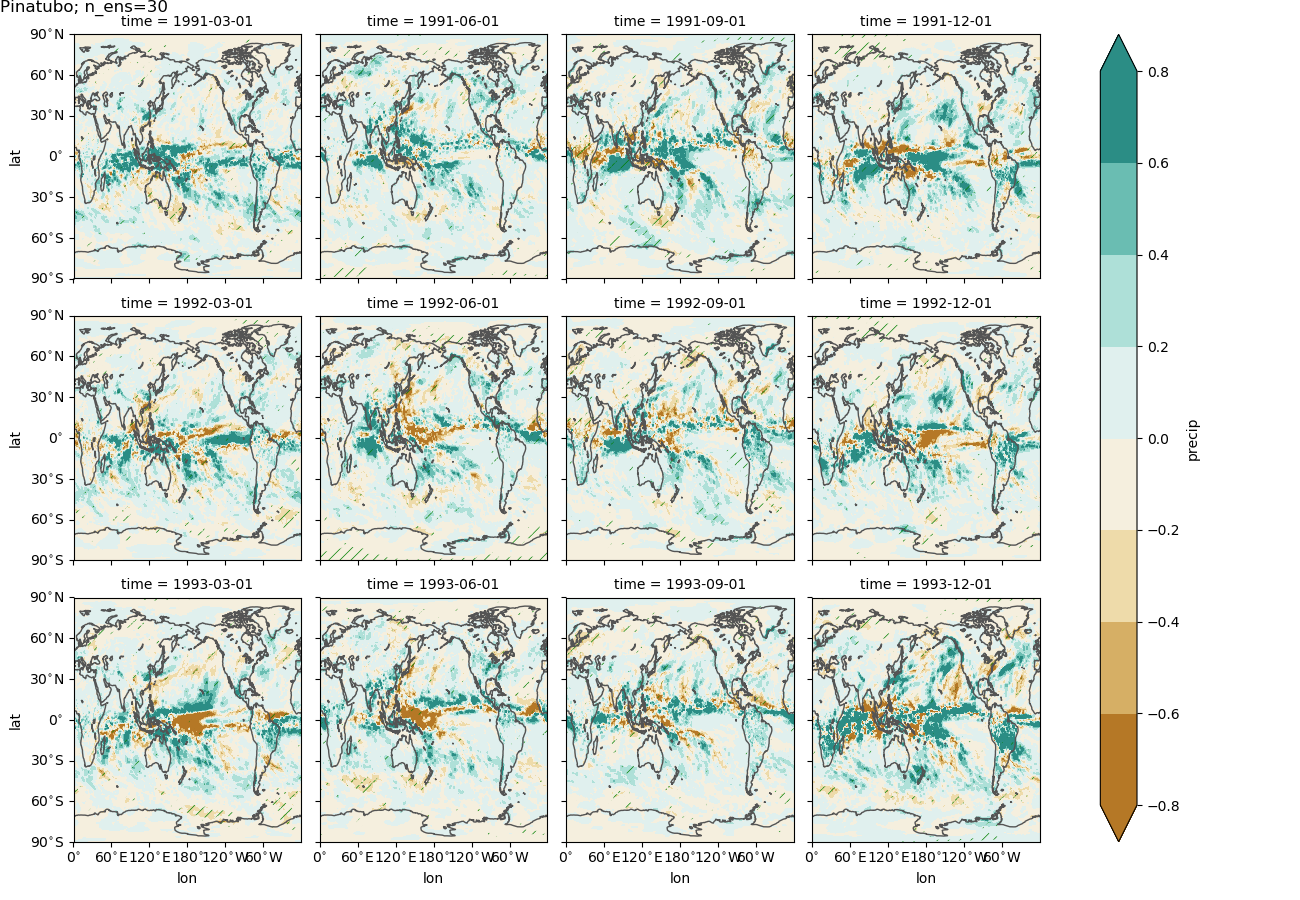

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [87]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both', cmap='BrBG')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

### Zonal mean

In [88]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.mean('lon') # zonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in list(da.dims)])

<IPython.core.display.Javascript object>


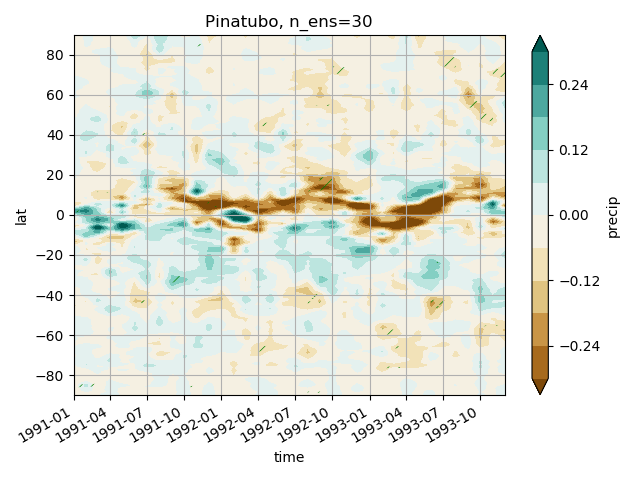

In [89]:
da.plot.contourf(x='time', y='lat', levels=10, robust=True, center=0, cmap='BrBG')
pvalue.where(pvalue<0.05).pipe(lambda x:x*0).plot.contourf(x='time', y='lat',
        colors='None', hatches=['///'], add_colorbar=False, add_labels=False)
plt.gcf().autofmt_xdate()
plt.title(f'{volcano_name}, n_ens={len(ens)}')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.tight_layout()

### ITCZ

<IPython.core.display.Javascript object>


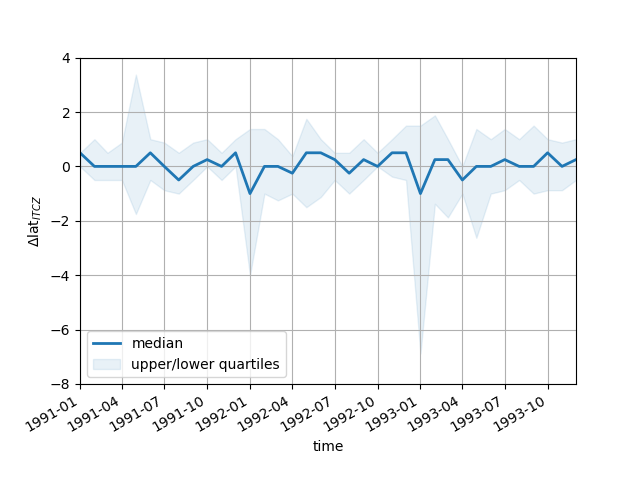

(-8, 4)

In [26]:
da_lonmean_ctl = da_ctl.mean('lon')
lat_itcz_ctl = da_lonmean_ctl.lat[da_lonmean_ctl.argmax('lat')]

da_lonmean_volc = da_volcano.mean('lon')
lat_itcz_volc = da_lonmean_volc.lat[da_lonmean_volc.argmax('lat')]

dlat_itcz = lat_itcz_volc - lat_itcz_ctl

plt.fill_between(dlat_itcz.time.to_index().to_pydatetime(),
    dlat_itcz.quantile(0.25, dim='en'),
    dlat_itcz.quantile(0.75, dim='en'),
    color='C0', alpha=0.1, label='upper/lower quartiles')
dlat_itcz.median('en').plot(color='C0', label='median')
xticksmonth(range(1,13,3))
plt.grid(True)
plt.xlim(dlat_itcz.isel(time=[0,-1]).time.to_index())
plt.ylabel('$\Delta$lat$_{ITCZ}$')
plt.legend(frameon=True, loc='lower left')
plt.ylim(-8,4)

## Sea level pressure ``slp``

In [96]:
data_name = 'slp'
# da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
# da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
ncfile = f'cache/{nbname}.{data_name}.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


Data calculated and saved to cache/volcano_impact_on_climate_pinatubo.ipynb.slp.ctl.nc
Data calculated and saved to cache/volcano_impact_on_climate_pinatubo.ipynb.slp.nc


In [97]:
# seasonal mean
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


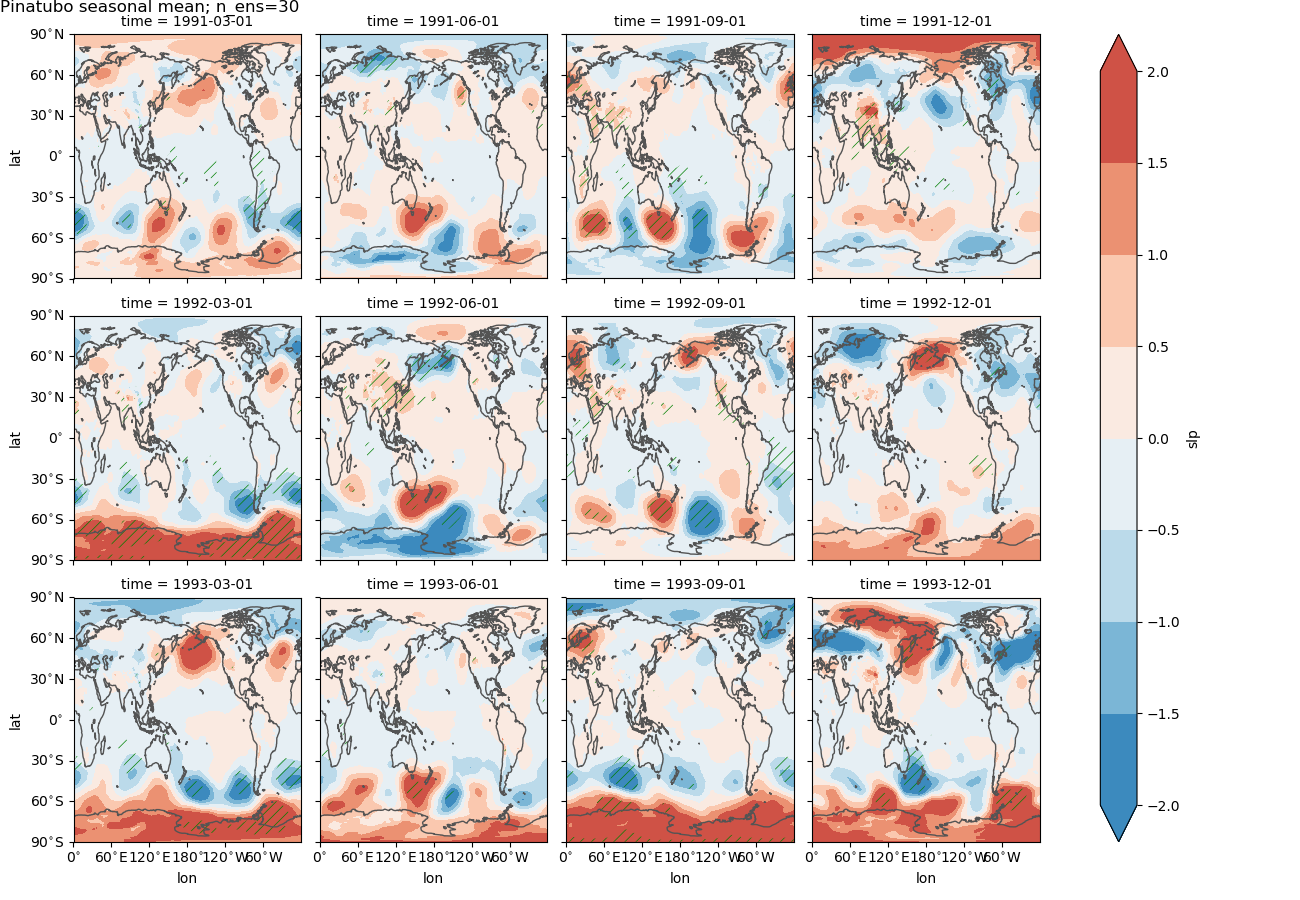

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [98]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name} seasonal mean; n_ens={len(ens)}', x=0, y=1, ha='left')

<IPython.core.display.Javascript object>


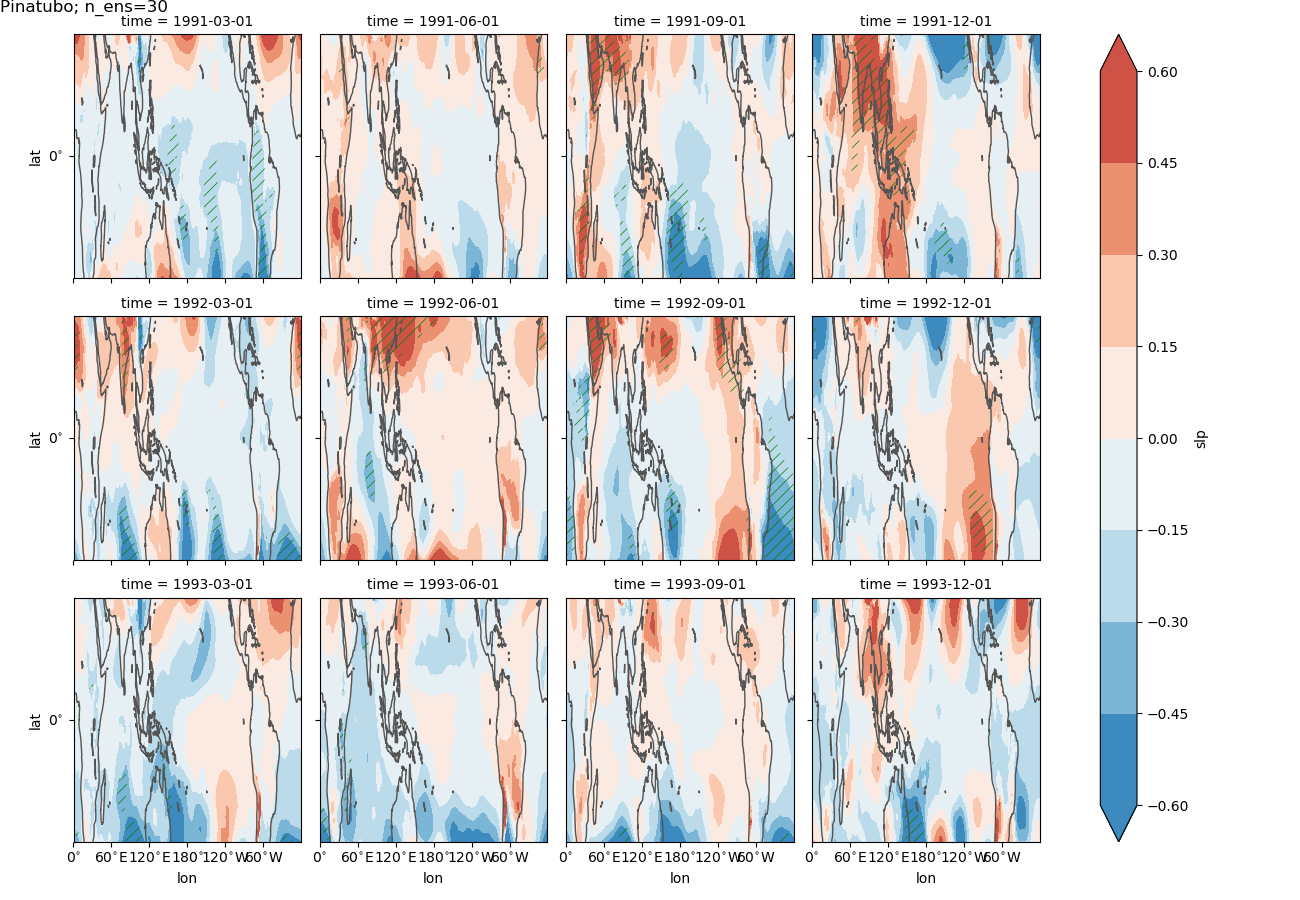

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/matplotlib/cbook.py:2649: UserWarning: Saw kwargs ['lw', 'linewidth'] which are all aliases for 'linewidth'.  Kept value from 'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


In [99]:
# tropics only
latrange = slice(-30,30)
f = da.sel(lat=latrange).plot.contourf(col='time', col_wrap=4,
    robust=True, levels=10, center=0, extend='both')
for ii, ax in enumerate(f.axes.flat):
    mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).sel(lat=latrange).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False)
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')

## Zonal-mean temperature ``temp``

In [100]:
data_name = 'temp'

ncfile = f'cache/{nbname}.{data_name}.lonmean.ctl.nc'
try:
    da_ctl = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_ctl = get_ctl(data_name, ens=ens, year_volcano=year_volcano).rename(new_names).mean('lon').load()
    da_ctl.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

ncfile = f'cache/{nbname}.{data_name}.lonmean.nc'
try:
    da_volcano = xr.open_dataarray(ncfile).load()
    print('Data loaded from', ncfile)
except:
    da_volcano = get_volcano(data_name, ens=ens).rename(new_names).mean('lon').load()
    da_volcano.to_dataset().to_netcdf(ncfile)
    print('Data calculated and saved to', ncfile)

/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/xarray/conventions.py:416: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/envs/intel/lib/python3.6/site-packages/xarray/conventions.py:435: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netCDF4.datetime objects instead, reason: dates out of range
  calendar=self.calendar)


Data calculated and saved to cache/volcano_impact_on_climate_pinatubo.ipynb.temp.lonmean.ctl.nc
Data calculated and saved to cache/volcano_impact_on_climate_pinatubo.ipynb.temp.lonmean.nc


In [101]:
daa = da_volcano - da_ctl# dims: en, time, grid_xt, grid_yt
daa = daa.resample(time='QS-Dec').mean('time').isel(time=slice(1, None)) # seasonal mean
tt, pp = ttest_1samp(daa, 0)
da = daa.mean('en').load()
pvalue = xr.DataArray(pp, dims=da.dims, coords=[da[dim] for dim in da.dims])

<IPython.core.display.Javascript object>


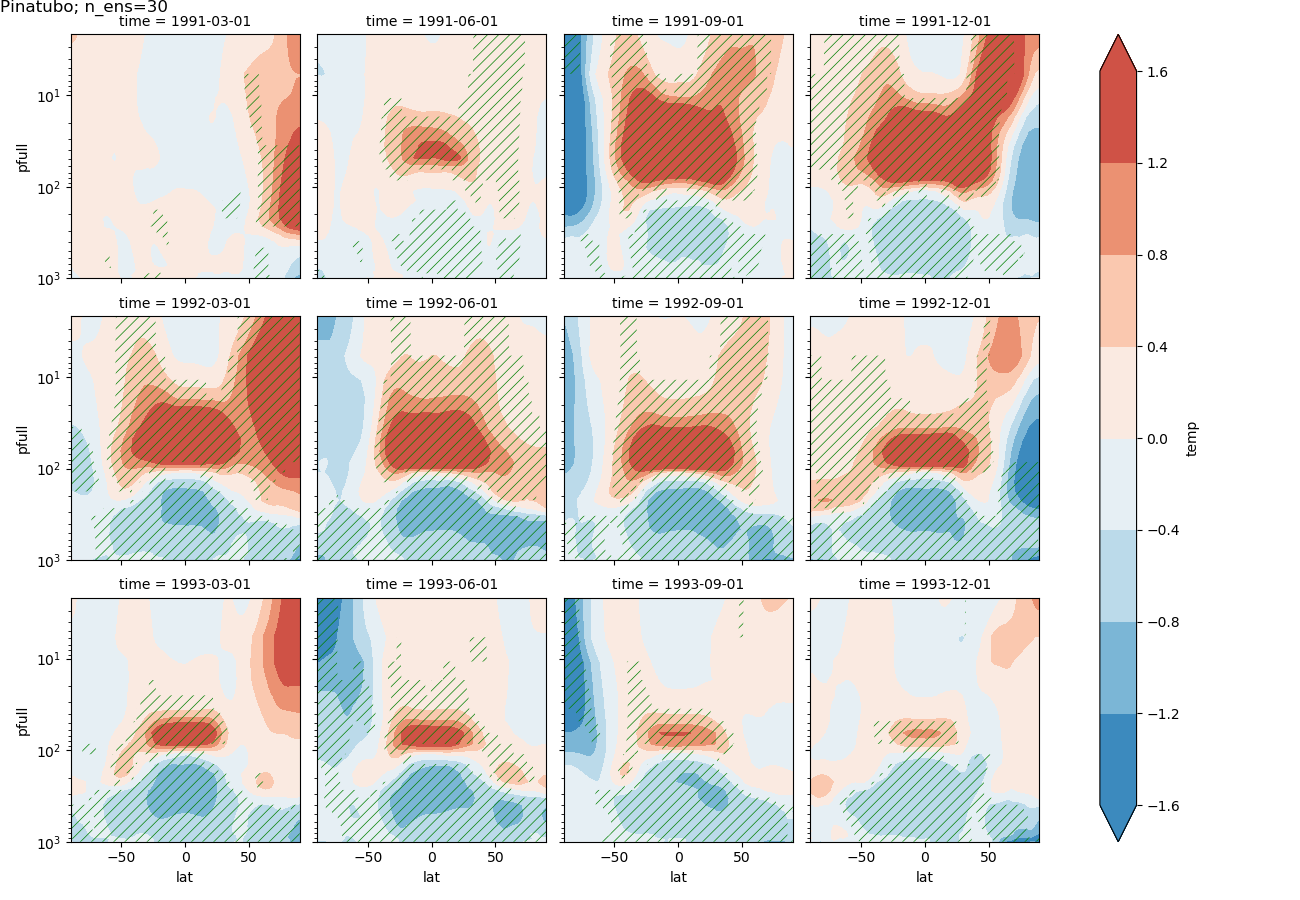

In [102]:
f = da.plot.contourf(col='time', col_wrap=4,
    robust=True, levels=np.arange(-1.6,1.61,0.4), center=0, extend='both', yincrease=False)
for ii, ax in enumerate(f.axes.flat):
#     mapplot(ax=ax, lw=0.2)
    pp = pvalue.isel(time=ii)
    pp.where(pp<0.05).pipe(lambda x:x*0).plot.contourf(ax=ax, 
        colors='None', hatches=['///'], facecolor='g', add_colorbar=False, add_labels=False, yincrease=False)
    ax.set_yscale('log')
plt.suptitle(f'{volcano_name}; n_ens={len(ens)}', x=0, y=1, ha='left')